## Table of Contents
- [Table of Contents](#table-of-contents)
- [1) Environment & Imports](#environment-imports)
- [2) Experiment Configuration](#experiment-configuration)
- [3) Decide Clip Length (Optional)](#decide-clip-length-optional)
- [4) Create Experiment Layout](#create-experiment-layout)
- [5) Prepare Dataset (Load / Split / Save Originals)](#prepare-dataset-load-split-save-originals)
- [6) Prepare Models](#prepare-models)
- [7) Sanity Checks](#sanity-checks)
- [8) Train & Evaluate (Optional)](#train-evaluate-optional)
- [9) Metrics & Plots (Optional)](#metrics-plots-optional)
- [Appendix — Tips & Troubleshooting](#appendix-tips-troubleshooting)

<a id="basic-example"></a>
# Basic Example

This notebook prepares data from the ZIPs (`real.zip`, `fake.zip`), loads **benchmark** models from torchvision (VGG, ResNet, ALEXNET) according to your configuration, and trains for **3 epochs** per transformation.

**Prerequisites**:
- ZIPs in `/content/drive/MyDrive/dataset` (at the repo root): `real.zip`, `fake.zip`
- (Optional) user-provided TorchScript models in `/content/drive/MyDrive/models`


Clone github repo:

In [ ]:
!git clone https://github.com/DEEP-CGPS/FakeVoiceFinder.git

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Import library

In [3]:
from pprint import pprint
from FakeVoiceFinder.fakevoicefinder import ExperimentConfig, CreateExperiment, ModelLoader, Trainer, ConfigError,shortest_audio_seconds


<a id="experiment-configuration"></a>
## 2) Experiment Configuration
<a id='sec2'></a>

**Goal:** Define models, transforms, and hyperparameters.

**Key fields in `ExperimentConfig`:**
- `models_list`: e.g., `['alexnet', 'resnet18', 'convnext_tiny']`
- `transform_list`: any of `['mel', 'log', 'dwt']`
- `mel_params`, `log_params`, `dwt_params`: optional **overrides** (dicts). Defaults are used if not set.
- `clip_seconds`: window length (seconds) for each audio (pad/trim). Default is 3.0 s.
- `image_size`: **optional** resize for MEL/LOG (e.g., `224` for ViT).

Tip: Keep defaults first; only override if you need a different setting.

In [4]:
cfg = ExperimentConfig()

# Experiment name (folder under outputs/)
cfg.run_name = "exp_v4"

# Paths (repo-relative)
cfg.data_path = "/content/drive/MyDrive/dataset"   # where reals.zip and fakes.zip are
cfg.models_path = "/content/drive/MyDrive/models"  # user TorchScript models

cfg.outputs_path = "/content/drive/MyDrive/outputs"
# Transforms to generate
cfg.transform_list = ["mel","dwt","log"]

# n_mels, n_fft, hop_length, win_length, fmin, fmax
cfg.mel_params = {
    "n_mels": 68,
    "n_fft": 2048,
    "hop_length": 512,
    # "win_length": None,
    # "fmin": 0,
    # "fmax": None,
}

# --- log: valid keys ---
# n_fft, hop_length, win_length
cfg.log_params = {
    "n_fft": 2048,
    "hop_length": 256,
    # "win_length": None,
}

# --- dwt: valid keys ---
# wavelet, level, mode
cfg.dwt_params = {
    "wavelet": "db6",
    "level": 5,
    "mode": "symmetric",
}

cfg.image_size = 224

# Benchmark models to test
cfg.models_list = ["alexnet","resnet18"]

# Quick smoke-test training
cfg.type_train = "both"   # 'scratch' | 'pretrain' | 'both'
cfg.epochs = 3
cfg.batch_size = 8
cfg.learning_rate = 0.0001
cfg.patience = 5

# Input channel for spectrograms (.npy): 1 channel
cfg.input_channels = 1

# Config validation
try:
    cfg.validate()
    print("Config validation ✅")
except ConfigError as e:
    print("Config validation error:", e)
    raise

print(cfg.summary())



Config validation ✅
ExperimentConfig:
  batch_size     : 8
  cache_features : True
  clip_seconds   : None
  data_path      : /content/drive/MyDrive/dataset
  device         : gpu
  dwt_params     : {'wavelet': 'db6', 'level': 5, 'mode': 'symmetric'}
  epochs         : 3
  eval_metric    : ['accuracy', 'F1']
  fake_zip       : fake.zip
  flag_train     : True
  image_size     : 224
  input_channels : 1
  learning_rate  : 0.0001
  log_params     : {'n_fft': 2048, 'hop_length': 256}
  mel_params     : {'n_mels': 68, 'n_fft': 2048, 'hop_length': 512}
  models_list    : ['alexnet', 'resnet18']
  models_path    : /content/drive/MyDrive/models
  num_workers    : 4
  optimizer      : Adam
  outputs_path   : /content/drive/MyDrive/outputs
  patience       : 5
  real_zip       : real.zip
  run_name       : exp_v4
  save_best_only : True
  save_models    : True
  seed           : 23
  transform_list : ['mel', 'dwt', 'log']
  type_train     : both


<a id="decide-clip-length-optional"></a>
## 3) Decide Clip Length (Optional)
<a id='sec3'></a>

**Goal:** Choose the time window (`clip_seconds`) to use for all audios.

Use `shortest_audio_seconds(cfg)` to scan `reals.zip` and `fakes.zip` and return the shortest duration in seconds. Then either:
- **A)** set `cfg.clip_seconds = min_duration` to avoid truncation; or
- **B)** choose a fixed value (e.g., 3.0 s). Short files will be **zero-padded** automatically.

In [5]:
# 2) Elegir la ventana de audio (clip_seconds)
min_sec = int(shortest_audio_seconds(cfg))
print(f"Duración mínima detectada en los zips: {min_sec}")

# Opción A: usar exactamente la mínima detectada
cfg.clip_seconds = min_sec

# Opción B: usar un valor fijo que tú prefieras (p. ej., 3.0 s)
# cfg.clip_seconds = 3.0

# Nota: si pones un valor mayor que muchos audios, se rellenará con padding (como ya hace el pipeline).


Duración mínima detectada en los zips: 4


<a id="create-experiment-layout"></a>
## 4) Create Experiment Layout
<a id='sec4'></a>

**Goal:** Initialize the experiment folder structure and manifest (`experiment.json`).

Run `CreateExperiment(cfg).build()` to set up:
- `outputs/<RUN>/datasets/{train,test}/...`
- `outputs/<RUN>/models/loaded/`
- `outputs/<RUN>/reports/`

The manifest stores paths and metadata for reproducibility.

In [6]:
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)
exp.build()

{'models': {'alexnet': {'loaded_path': None,
   'trained_path': None,
   'train_parameters': {'epochs': 3,
    'learning_rate': 0.0001,
    'batch_size': 8,
    'optimizer': 'Adam',
    'patience': 5,
    'device': 'gpu',
    'seed': 23,
    'type_train': 'both',
    'num_workers': 4,
    'transform': None}},
  'resnet18': {'loaded_path': None,
   'trained_path': None,
   'train_parameters': {'epochs': 3,
    'learning_rate': 0.0001,
    'batch_size': 8,
    'optimizer': 'Adam',
    'patience': 5,
    'device': 'gpu',
    'seed': 23,
    'type_train': 'both',
    'num_workers': 4,
    'transform': None}}},
 'train_data': {'original_dataset': {'path': '../drive/MyDrive/outputs/exp_v4/datasets/train/original',
   'num_items': 0},
  'transforms_dataset': {'mel': {'path': '../drive/MyDrive/outputs/exp_v4/datasets/train/transforms/mel',
    'params': {}},
   'dwt': {'path': '../drive/MyDrive/outputs/exp_v4/datasets/train/transforms/dwt',
    'params': {}},
   'log': {'path': '../drive/MyDri

<a id="prepare-dataset-load-split-save-originals"></a>
## 5) Prepare Dataset (Load / Split / Save Originals / Transform)
<a id='sec5'></a>

**Goal:**
1) Read `real.zip` and `fake.zip`.
2) Stratified split into train/test.
3) Extract original audio files into the experiment folders.
4) Generate Transforms (MEL / LOG / DWT)

In [7]:
summary = exp.prepare_data(train_ratio=0.8, seed=cfg.seed, transforms=cfg.transform_list)
print("Data prep summary:")
pprint(summary)

print("Manifest:", (exp.root / "experiment.json").as_posix())

Data prep summary:
{'load': {'fake': 600, 'real': 600},
 'save_original': {'test': 240, 'train': 960},
 'split': {'test': {'fake': 120, 'real': 120, 'total': 240},
           'train': {'fake': 480, 'real': 480, 'total': 960}},
 'transforms': {'dwt': {'test': 240, 'train': 960},
                'log': {'test': 240, 'train': 960},
                'mel': {'test': 240, 'train': 960}}}
Manifest: /content/drive/MyDrive/outputs/exp_v4/experiment.json


<a id="prepare-models"></a>
## 6) Prepare Models

In [8]:
loader = ModelLoader(exp)
bench = loader.prepare_benchmarks(add_softmax=False, input_channels=getattr(cfg, "input_channels", 1))
print("Benchmarks saved under models/loaded:")
pprint(bench)

# User models (if any .pt/.pth under cfg.models_path)
user = loader.prepare_user_models(add_softmax=False, input_channels=cfg.input_channels)
print("User models saved:")
pprint(user)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 174MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


Benchmarks saved under models/loaded:
{'alexnet': {'pretrain': '../drive/MyDrive/outputs/exp_v4/models/loaded/alexnet_pretrain.pt',
             'scratch': '../drive/MyDrive/outputs/exp_v4/models/loaded/alexnet_scratch.pt'},
 'resnet18': {'pretrain': '../drive/MyDrive/outputs/exp_v4/models/loaded/resnet18_pretrain.pt',
              'scratch': '../drive/MyDrive/outputs/exp_v4/models/loaded/resnet18_scratch.pt'}}
User models saved:
{}


<a id="sanity-checks"></a>
## 7) Sanity Checks
<a id='sec7'></a>

**Goal:** Verify shapes and parameters saved to the manifest.

- Load one `.npy` per class and print its shape.
- Inspect `experiment.json` parameters under `train_data.transforms_dataset[<name>].params`.

In [9]:
def print_tree(root, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
   📁 trained
📁 reports
📄 experiment.json


<a id="train-evaluate-optional"></a>
## 8) Train & Evaluate (Optional)
<a id='sec8'></a>

**Goal:** Train your selected models and compute metrics on the test split.

- Use your training loop or the provided trainer to fit each model.
- Evaluate with `MetricsReporter` to build a DataFrame of scores (Accuracy, F1).

In [10]:
trainer = Trainer(exp)
train_results = trainer.train_all()
print("Resultados de entrenamiento (rutas repo-relativas):")
pprint(train_results)

print("Best checkpoints stored in:", (exp.trained_models).as_posix())


[Trainer] Using device: cuda
[Trainer] Transforms to train: ['mel', 'dwt', 'log']
[Trainer] Models found: ['alexnet', 'resnet18']

=== MODEL: alexnet ===
[alexnet] Hyperparams -> epochs=3, lr=0.0001, bs=8, optimizer=Adam, patience=5, seed=23, num_workers=4
[alexnet][mel] Dataset sizes -> train: 1920, test: 480
[alexnet][mel] Batches -> train: 240, test: 60
[alexnet][mel][scratch] Loading checkpoint: /content/FakeVoiceFinder/../drive/MyDrive/outputs/exp_v4/models/loaded/alexnet_scratch.pt


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[alexnet][mel][scratch] Loaded pickled module.
[alexnet][mel][scratch] Start training for 3 epochs
[alexnet][mel][scratch] Epoch 1/3 - loss=0.6934 acc=0.5667
[alexnet][mel][scratch] Confusion matrix (test):
[[TN=  36, FP= 204],
 [FN=   4, TP= 236]]
[alexnet][mel][scratch] ✅ New best acc=0.5667 at epoch 1
[alexnet][mel][scratch] Epoch 2/3 - loss=0.5609 acc=0.7542
[alexnet][mel][scratch] Confusion matrix (test):
[[TN= 128, FP= 112],
 [FN=   6, TP= 234]]
[alexnet][mel][scratch] ✅ New best acc=0.7542 at epoch 2
[alexnet][mel][scratch] Epoch 3/3 - loss=0.3371 acc=0.8542
[alexnet][mel][scratch] Confusion matrix (test):
[[TN= 180, FP=  60],
 [FN=  10, TP= 230]]
[alexnet][mel][scratch] ✅ New best acc=0.8542 at epoch 3
[alexnet][mel] Saved best checkpoint -> alexnet_scratch_mel_seed23_epoch003_acc0.85.pt
[alexnet][mel][pretrain] Loading checkpoint: /content/FakeVoiceFinder/../drive/MyDrive/outputs/exp_v4/models/loaded/alexnet_pretrain.pt
[alexnet][mel][pretrain] Loaded pickled module.
[alexnet]

In [11]:
def print_tree(root, max_depth: int = 3, prefix: str = ""):
    if max_depth < 0:
        return
    try:
        entries = sorted(root.iterdir(), key=lambda p: (p.is_file(), p.name.lower()))
    except FileNotFoundError:
        return
    for e in entries:
        print(prefix + ("📄 " if e.is_file() else "📁 ") + e.name)
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix + "   ")

print_tree(exp.root, max_depth=3)

📁 datasets
   📁 test
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
   📁 train
      📁 original
         📁 fake
         📁 real
      📁 transforms
         📁 dwt
         📁 log
         📁 mel
📁 models
   📁 loaded
      📄 alexnet_pretrain.pt
      📄 alexnet_scratch.pt
      📄 resnet18_pretrain.pt
      📄 resnet18_scratch.pt
   📁 trained
      📄 alexnet_pretrain_dwt_seed23_epoch002_acc0.83.pt
      📄 alexnet_pretrain_log_seed23_epoch003_acc0.93.pt
      📄 alexnet_pretrain_mel_seed23_epoch003_acc0.95.pt
      📄 alexnet_scratch_dwt_seed23_epoch002_acc0.83.pt
      📄 alexnet_scratch_log_seed23_epoch003_acc0.78.pt
      📄 alexnet_scratch_mel_seed23_epoch003_acc0.85.pt
      📄 resnet18_pretrain_dwt_seed23_epoch001_acc0.93.pt
      📄 resnet18_pretrain_log_seed23_epoch001_acc0.99.pt
      📄 resnet18_pretrain_mel_seed23_epoch003_acc0.97.pt
      📄 resnet18_scratch_dwt_seed23_epoch003_acc0.90.pt
      📄 resnet18_scratch_log_seed23_

<a id="metrics-plots-optional"></a>
## 9) Metrics & Plots (Optional)
<a id='sec9'></a>

**Goal:** Visualize results.

- `plot_architectures_for_transform`: bar chart of `(model+variant)` for a single transform.
- `plot_variants_for_model`: bar chart of `(transform)` for a single `(model, variant)`.
- `plot_heatmap_models_transforms`: heatmap over `(models×variants) × transforms`.

**Color map defaults:** worst value → red, better → green, max at 100%. Each cell shows its value in %.

In [12]:
from FakeVoiceFinder.fakevoicefinder.config import ExperimentConfig
from FakeVoiceFinder.fakevoicefinder.experiment import CreateExperiment
from FakeVoiceFinder.fakevoicefinder.metrics import MetricsReporter

EXP_NAME = cfg.run_name
OUTPUTS_PATH = cfg.outputs_path
cfg = ExperimentConfig(); cfg.run_name = EXP_NAME
cfg.outputs_path = OUTPUTS_PATH
exp = CreateExperiment(cfg, experiment_name=cfg.run_name)

rep = MetricsReporter(exp)                   # toma reports/ del manifest
df = rep.evaluate_all("metrics_summary.csv") # guarda CSV en outputs/<exp>/reports/

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: T

[metrics] CSV saved -> /content/drive/MyDrive/outputs/exp_v4/reports/metrics_summary.csv


In [13]:
df

,model,variant,transform,accuracy,f1,f1_macro,f1_micro,precision,recall,checkpoint
0,alexnet,pretrain,dwt,69.17,76.28,66.12,69.17,61.98,99.17,../drive/MyDrive/outputs/exp_v4/models/trained...
1,alexnet,scratch,dwt,75.00,79.59,73.67,75.00,67.24,97.50,../drive/MyDrive/outputs/exp_v4/models/trained...
2,resnet18,pretrain,dwt,85.83,87.50,85.58,85.83,78.29,99.17,../drive/MyDrive/outputs/exp_v4/models/trained...
3,resnet18,scratch,dwt,89.58,89.27,89.57,89.58,92.04,86.67,../drive/MyDrive/outputs/exp_v4/models/trained...
4,alexnet,pretrain,log,93.33,93.04,93.32,93.33,97.27,89.17,../drive/MyDrive/outputs/exp_v4/models/trained...
5,alexnet,scratch,log,77.92,80.73,77.44,77.92,71.61,92.50,../drive/MyDrive/outputs/exp_v4/models/trained...
6,resnet18,pretrain,log,98.75,98.73,98.75,98.75,100.00,97.50,../drive/MyDrive/outputs/exp_v4/models/trained...
7,resnet18,scratch,log,94.17,94.35,94.16,94.17,91.41,97.50,../drive/MyDrive/outputs/exp_v4/models/trained...
8,alexnet,pretrain,mel,94.58,94.69,94.58,94.58,92.80,96.67,../drive/MyDrive/outputs/exp_v4/models/trained...
9,alexnet,scratch,mel,85.42,86.79,85.26,85.42,79.31,95.83,../drive/MyDrive/outputs/exp_v4/models/trained...


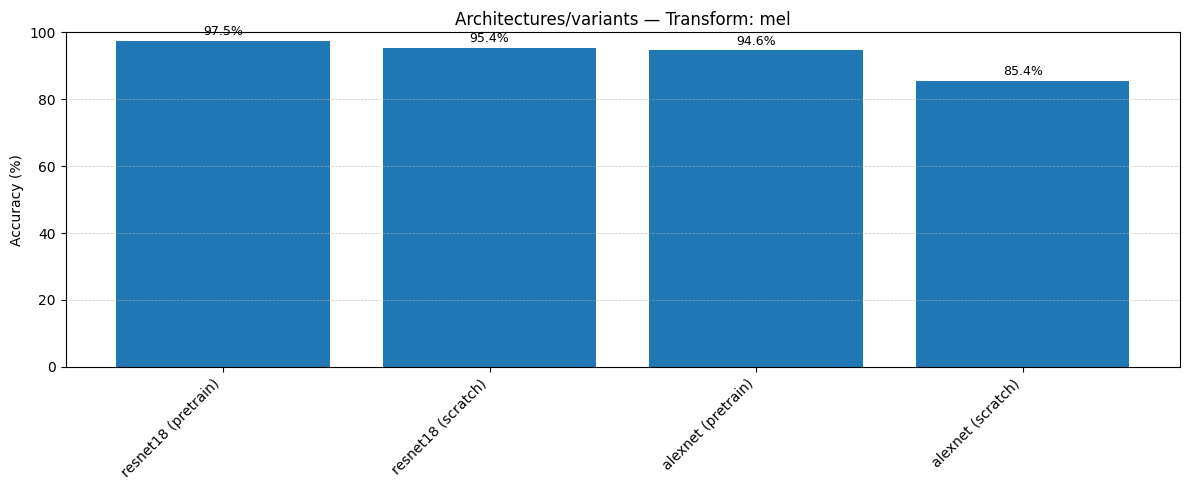

[metrics] Figure saved -> /content/drive/MyDrive/outputs/exp_v4/reports/fig_arch_mel_acc.png


In [17]:
# Figuras (se guardan en 'reports/' al pasar out_name)
rep.plot_architectures_for_transform(df, transform="mel", metric="accuracy",
                                     y_min=0, y_max=100, out_name="fig_arch_mel_acc.png")


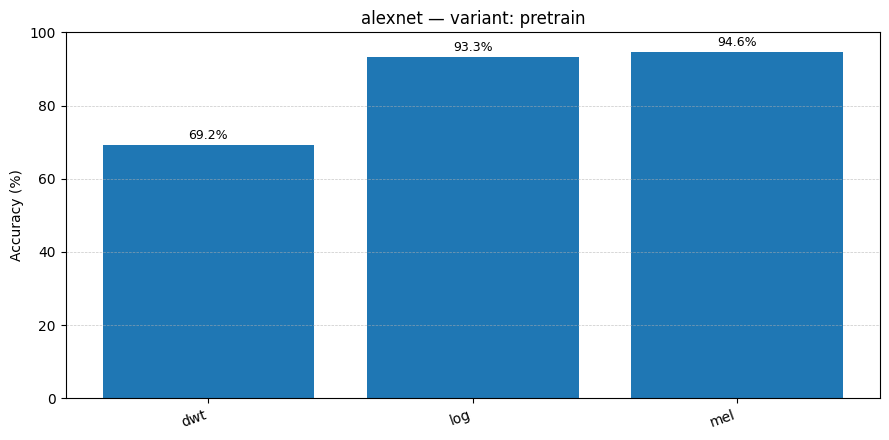

[metrics] Figure saved -> /content/drive/MyDrive/outputs/exp_v4/reports/fig_alexnet_pretrain_accuracy.png


In [18]:
rep.plot_variants_for_model(df, model="alexnet", variant="pretrain", metric="accuracy",
                              y_min=0, y_max=100, out_name="fig_alexnet_pretrain_accuracy.png")


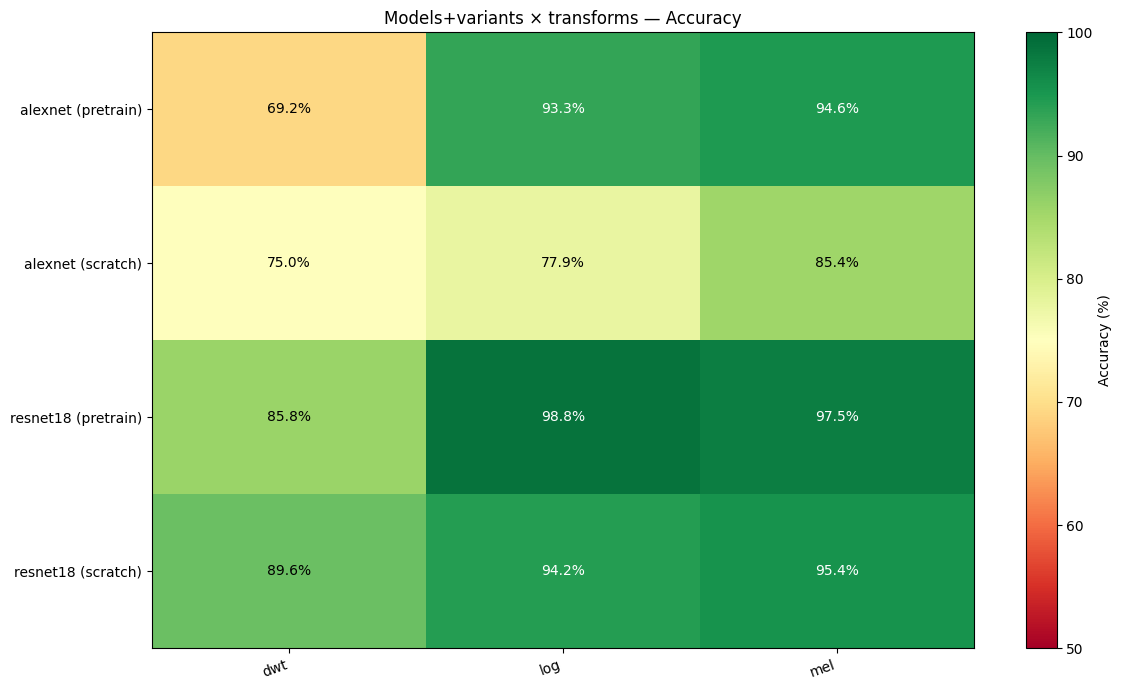

[metrics] Figure saved -> /content/drive/MyDrive/outputs/exp_v4/reports/fig_all.png


In [19]:
rep.plot_heatmap_models_transforms(df, metric="accuracy", vmin=50, vmax=100,
                                   out_name="fig_all.png")


<a id="appendix-tips-troubleshooting"></a>
## Appendix — Tips & Troubleshooting
<a id='sec10'></a>

- If using ViT/ConvNeXt, prefer **224×224** inputs. Set `cfg.image_size = 224` (MEL/LOG) or use **DWT**.
- If audio files vary in length, pick an appropriate `clip_seconds`. Shorter files are zero-padded.
- If you change transform hyperparameters, rerun the transform step to regenerate features.
- Ensure CUDA is available if `cfg.device='gpu'`. Otherwise, it will fall back to CPU.
- Check `outputs/<RUN>/reports/` for figures and CSVs.